## Python Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import time
import os
from itertools import chain
from tqdm import tqdm 

from module.smatrix import Multilayer
from module.utility import constant_index, make_layer, load_data
'''
Si의 n과 k를 4000이하까지 확장하자.
'''

'\nSi의 n과 k를 4000이하까지 확장하자.\n'

In [2]:
#2020-08-09: 두께는 동일, 레벨만 변화시켜본다.
#2020-08-10: level을 맞추는 듯 했으나, 두께 오차가 생각보다 크다.->Fitting_n,k를 써보자. 원본은 SiO2의 굴절률이 급격히 변하면서 반사에서 반영이되어 나타났음.
#2020-08-16: k가 축소되면서, 전체적으로 원본과 레벨오차가 줄어들음.
#2020-08-22: level은 np.linspace를 이용, -100부터 100의 level dispersion을 만들자.
#2020-08-23: point를 801로 계산
#2020-08-28: level 범위 + -5%
#2020-12-02: nk-combination 적용

## Data Set

In [3]:
#@jit(target="cuda")
def df_one_row(n_sio2, k_sio2, d_sio2_1,level, params, noise_level=0):
    para=params[:]
    # Structure
    layer_air = make_layer(nk_air)
    #layer_igzo = make_layer(nk_igzo, thickness=d_igzo*1e-7, coherence=True)
    layer_sio2_1 = make_layer(n_sio2 + 1j*k_sio2, thickness=d_sio2_1*1e-7, coherence=True)
    layer_si = make_layer(nk_si, thickness=0.05, coherence=False)
    #layer_sio2_2 = make_layer(nk_sio2, thickness=d_sio2_2*1e-7, coherence=True)
    structure = [
        layer_air,
        layer_sio2_1,
        layer_si,
        layer_sio2_1,
        layer_air]
    
    R = Multilayer(structure, 0, 's', wavenumbers).R()
    noise = (2*np.random.rand(len(wavenumbers))-1)/100
    #T += noise * noise_level
    #R += level
    R += level/100
    #R *= 1+(2*np.random.rand()-1)/100
    R = R.reshape(1, -1)
    
    label = np.array([d_sio2_1]).reshape(1, -1)
    
    df_1 = pd.DataFrame(data=np.array(para).reshape(1,-1), columns=['e_inf','w01','wp1','gamma1','w02','wp2','gamma2'])
    df_2 = pd.DataFrame(data=label, columns=['두께(nm)'])
    df_3= pd.DataFrame(data=[level], columns=['level']) #level 변환
    df_4 = pd.DataFrame(data=R, columns=wavenumbers)
    df = pd.concat([df_1,df_2,df_3,df_4], axis=1)
    return df

def linspace(a, b, step):
    out = []
    i = a
    while i <= b:
        out.append(i)
        i += step
    return out

In [4]:
def epsilon(wavenumbers, w_0, w_p, gamma):
    e1=np.power(w_p,2)*(w_0**2 - wavenumbers**2)/(( np.power(wavenumbers,2) - np.power(w_0,2) )**2+(w_0*gamma)**2)
    e2=wavenumbers * gamma *np.power(w_p,2) / ( (w_0*gamma)**2 + ( np.power(wavenumbers,2) - np.power(w_0,2) )**2)
    return e1+1j*e2

def refractive(wavenumbers, params ):
    paramsRest = params[1:] # params[j][0] #e_inf
    #print(paramsRest)
    #print(len(paramsRest))
    e_inf=params[0]
    e= e_inf + sum( [ epsilon( wavenumbers, *paramsRest[  j:j+3 ] ) for j in range( 0, len( paramsRest),3 )  ] )  
    n=np.real(np.sqrt(e))
    k=np.imag(np.sqrt(e))
    return n,k

In [5]:
wavenumbers=np.linspace(1000,8000,351)

In [6]:
nk_air = constant_index(1, wavenumbers)
# Si
si_n = load_data('refractive_index/Silicon_n.csv', wavenumbers)
si_k = load_data('refractive_index/Silicon_k.csv', wavenumbers)
nk_si = si_n + 1j * si_k

## Train Data

In [7]:
random.seed(0)
np.random.seed(0)
df_list = []
d_i = 250
d_f = 300
step = 1
start_time = time.time()
end = np.power(((d_f - d_i)/step + 1),1)
i = 1
e=np.linspace(1.5,2.5,11)
w0=np.linspace(0,2000,41)
wp=np.linspace(0,1000,21)
gamma=np.linspace(8,32,4)
for i in tqdm(range(6001)): #4000회: 20gb 사용. --> 3gb 저장. --> 17gb 가 list 저장 작업에 사용됨.
    e_inf=np.random.choice(e,1)
    w0_1,w0_2=np.random.choice(w0,2,replace=False)
    wp_1,wp_2=np.random.choice(wp,2,replace=True)
    gamma1,gamma2=np.random.choice(gamma,2,replace=True)
    parr=[e_inf,[w0_1,wp_1,gamma1,w0_2,wp_2,gamma2]]
    parr=list(chain(*parr))
    n,k=refractive(wavenumbers, parr)
    for d_sio2_1 in linspace(d_i, d_f, step):
        for level in np.linspace(-4,4,5): 
            
            df = df_one_row(n, k, d_sio2_1, level, parr, noise_level=0)
            df_list.append(df)
            
data = pd.concat(df_list).reset_index(drop=True)
data.head()
#data.head()
#data.head(10)

100%|████████████████████████████████████████████████████████████████████████████| 6001/6001 [1:59:34<00:00,  1.20s/it]


,e_inf,w01,wp1,gamma1,w02,wp2,gamma2,두께(nm),level,1000.0,...,7820.0,7840.0,7860.0,7880.0,7900.0,7920.0,7940.0,7960.0,7980.0,8000.0
0,2.0,1250.0,0.0,8.0,1750.0,500.0,32.0,250,-4.0,0.412769,...,0.054436,0.054759,0.055094,0.055477,0.055922,0.056294,0.056678,0.057073,0.057599,0.058017
1,2.0,1250.0,0.0,8.0,1750.0,500.0,32.0,250,-2.0,0.432769,...,0.074436,0.074759,0.075094,0.075477,0.075922,0.076294,0.076678,0.077073,0.077599,0.078017
2,2.0,1250.0,0.0,8.0,1750.0,500.0,32.0,250,0.0,0.452769,...,0.094436,0.094759,0.095094,0.095477,0.095922,0.096294,0.096678,0.097073,0.097599,0.098017
3,2.0,1250.0,0.0,8.0,1750.0,500.0,32.0,250,2.0,0.472769,...,0.114436,0.114759,0.115094,0.115477,0.115922,0.116294,0.116678,0.117073,0.117599,0.118017
4,2.0,1250.0,0.0,8.0,1750.0,500.0,32.0,250,4.0,0.492769,...,0.134436,0.134759,0.135094,0.135477,0.135922,0.136294,0.136678,0.137073,0.137599,0.138017


In [8]:
data.to_csv('train_parameter.csv', index=False)

In [9]:
len(data)

1530255

In [10]:
data.describe()

,e_inf,w01,wp1,gamma1,w02,wp2,gamma2,두께(nm),level,1000.0,...,7820.0,7840.0,7860.0,7880.0,7900.0,7920.0,7940.0,7960.0,7980.0,8000.0
count,1.530255e+06,1.530255e+06,1.530255e+06,1.530255e+06,1.530255e+06,1.530255e+06,1.530255e+06,1.530255e+06,1.530255e+06,1.530255e+06,...,1.530255e+06,1.530255e+06,1.530255e+06,1.530255e+06,1.530255e+06,1.530255e+06,1.530255e+06,1.530255e+06,1.530255e+06,1.530255e+06
mean,2.001500e+00,1.008024e+03,5.021246e+02,1.990335e+01,9.949092e+02,4.991751e+02,1.991935e+01,2.750000e+02,0.000000e+00,4.566665e-01,...,1.405706e-01,1.412515e-01,1.419398e-01,1.426832e-01,1.435013e-01,1.442095e-01,1.449238e-01,1.456447e-01,1.465339e-01,1.472664e-01
std,3.166140e-01,5.964900e+02,3.018691e+02,8.898924e+00,5.958199e+02,3.001468e+02,8.939737e+00,1.471961e+01,2.828428e+00,4.510418e-02,...,4.014832e-02,4.007552e-02,4.000898e-02,3.995368e-02,3.991139e-02,3.986264e-02,3.981969e-02,3.978244e-02,3.976691e-02,3.974041e-02
min,1.500000e+00,0.000000e+00,0.000000e+00,8.000000e+00,0.000000e+00,0.000000e+00,8.000000e+00,2.500000e+02,-4.000000e+00,3.283312e-01,...,4.232663e-02,4.316234e-02,4.400096e-02,4.487179e-02,4.579907e-02,4.665983e-02,4.753072e-02,4.841196e-02,4.941358e-02,5.022126e-02
25%,1.700000e+00,5.000000e+02,2.500000e+02,8.000000e+00,5.000000e+02,2.500000e+02,8.000000e+00,2.620000e+02,-2.000000e+00,4.273002e-01,...,1.120546e-01,1.129207e-01,1.138314e-01,1.148181e-01,1.157176e-01,1.163890e-01,1.170386e-01,1.176839e-01,1.184274e-01,1.190642e-01
50%,2.000000e+00,1.000000e+03,5.000000e+02,1.600000e+01,1.000000e+03,5.000000e+02,2.400000e+01,2.750000e+02,0.000000e+00,4.531789e-01,...,1.407147e-01,1.411900e-01,1.417262e-01,1.423043e-01,1.430059e-01,1.436029e-01,1.442584e-01,1.450137e-01,1.459265e-01,1.466757e-01
75%,2.300000e+00,1.550000e+03,7.500000e+02,2.400000e+01,1.500000e+03,7.500000e+02,2.400000e+01,2.880000e+02,2.000000e+00,4.803264e-01,...,1.691320e-01,1.698675e-01,1.706340e-01,1.715363e-01,1.725111e-01,1.734002e-01,1.743617e-01,1.752065e-01,1.761121e-01,1.767839e-01
max,2.500000e+00,2.000000e+03,1.000000e+03,3.200000e+01,2.000000e+03,1.000000e+03,3.200000e+01,3.000000e+02,4.000000e+00,8.331850e-01,...,2.455798e-01,2.470202e-01,2.484536e-01,2.499424e-01,2.515126e-01,2.529222e-01,2.543235e-01,2.557171e-01,2.573145e-01,2.586907e-01


<AxesSubplot:>

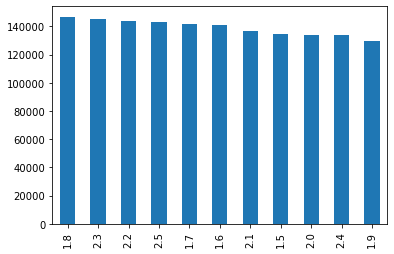

In [13]:
data['e_inf'].value_counts().plot(kind='bar')

In [14]:
data=data.drop_duplicates(['e_inf','w01','wp1','gamma1','w02','wp2','gamma2','두께(nm)','level'],keep='first')# <--이 경우의 len(data)의 변동이 없으므로 상대적으로 중복이 안됨을 알 수 있음.
data

,e_inf,w01,wp1,gamma1,w02,wp2,gamma2,두께(nm),level,1000.0,...,7820.0,7840.0,7860.0,7880.0,7900.0,7920.0,7940.0,7960.0,7980.0,8000.0
0,2.0,1250.0,0.0,8.0,1750.0,500.0,32.0,250,-4.0,0.412769,...,0.054436,0.054759,0.055094,0.055477,0.055922,0.056294,0.056678,0.057073,0.057599,0.058017
1,2.0,1250.0,0.0,8.0,1750.0,500.0,32.0,250,-2.0,0.432769,...,0.074436,0.074759,0.075094,0.075477,0.075922,0.076294,0.076678,0.077073,0.077599,0.078017
2,2.0,1250.0,0.0,8.0,1750.0,500.0,32.0,250,0.0,0.452769,...,0.094436,0.094759,0.095094,0.095477,0.095922,0.096294,0.096678,0.097073,0.097599,0.098017
3,2.0,1250.0,0.0,8.0,1750.0,500.0,32.0,250,2.0,0.472769,...,0.114436,0.114759,0.115094,0.115477,0.115922,0.116294,0.116678,0.117073,0.117599,0.118017
4,2.0,1250.0,0.0,8.0,1750.0,500.0,32.0,250,4.0,0.492769,...,0.134436,0.134759,0.135094,0.135477,0.135922,0.136294,0.136678,0.137073,0.137599,0.138017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530250,2.5,1700.0,750.0,16.0,300.0,100.0,16.0,300,-4.0,0.399789,...,0.164470,0.165916,0.167354,0.168849,0.170424,0.171839,0.173246,0.174646,0.176249,0.177631
1530251,2.5,1700.0,750.0,16.0,300.0,100.0,16.0,300,-2.0,0.419789,...,0.184470,0.185916,0.187354,0.188849,0.190424,0.191839,0.193246,0.194646,0.196249,0.197631
1530252,2.5,1700.0,750.0,16.0,300.0,100.0,16.0,300,0.0,0.439789,...,0.204470,0.205916,0.207354,0.208849,0.210424,0.211839,0.213246,0.214646,0.216249,0.217631
1530253,2.5,1700.0,750.0,16.0,300.0,100.0,16.0,300,2.0,0.459789,...,0.224470,0.225916,0.227354,0.228849,0.230424,0.231839,0.233246,0.234646,0.236249,0.237631


In [15]:
data.to_csv('train_parameter.csv', index=False)

# Result generation

In [21]:
path='result_same_layer_para.csv'
result=pd.read_csv(path)

In [22]:
df_result=[]

In [23]:
for i in range(6):
    parameter=result.iloc[i,1:8].to_list()
    d_sio2=result.iloc[i,8]
    level=result.iloc[i,9]
    n,k=refractive(wavenumbers, parameter)
    df = df_one_row(n,k,d_sio2,level,parameter)
    df_result.append(df)

In [24]:
result_data=pd.concat(df_result).reset_index(drop=True)
result_data=result_data.T
result_data.to_excel('result_para.xlsx')